In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import os
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [20]:
# 1. Daten laden
required_files = ["umsatzdaten_gekuerzt.csv", "kiwo.csv", "wetter.csv", "Data Import and Preparation/feiertage.csv"]
for file in required_files:
    if not os.path.exists(file):
        raise FileNotFoundError(f"Datei '{file}' nicht gefunden.")

umsatzdaten = pd.read_csv("umsatzdaten_gekuerzt.csv")
kiwo_data = pd.read_csv("kiwo.csv")
wetter_data = pd.read_csv("wetter.csv")
feiertage = pd.read_csv("Data Import and Preparation/feiertage.csv")

In [21]:
# 2. Datum anpassen und konvertieren
umsatzdaten['Datum'] = pd.to_datetime(umsatzdaten['Datum'], errors='coerce')
kiwo_data['Datum'] = pd.to_datetime(kiwo_data['Datum'], errors='coerce')
wetter_data['Datum'] = pd.to_datetime(wetter_data['Datum'], errors='coerce')

# Feiertags-Datum anpassen
feiertage['Datum'] = feiertage['Datum'].apply(
    lambda x: f"{str(x).strip()} 2017" if isinstance(x, str) else None
)
feiertage['Datum'] = pd.to_datetime(feiertage['Datum'], format='%d. %b %Y', errors='coerce')

In [22]:
# 3. Daten zusammenführen
merged_data = umsatzdaten.merge(kiwo_data, on='Datum', how='left')
merged_data = merged_data.merge(wetter_data, on='Datum', how='left')
merged_data = merged_data.merge(feiertage[['Datum', 'Name']], on='Datum', how='left')

C:\Users\ayham\AppData\Local\Temp\ipykernel_6564\4194825154.py:34: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = stats.sem(data)  # Standardfehler des Mittelwerts
C:\Users\ayham\AppData\Local\Temp\ipykernel_6564\4194825154.py:34: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = stats.sem(data)  # Standardfehler des Mittelwerts


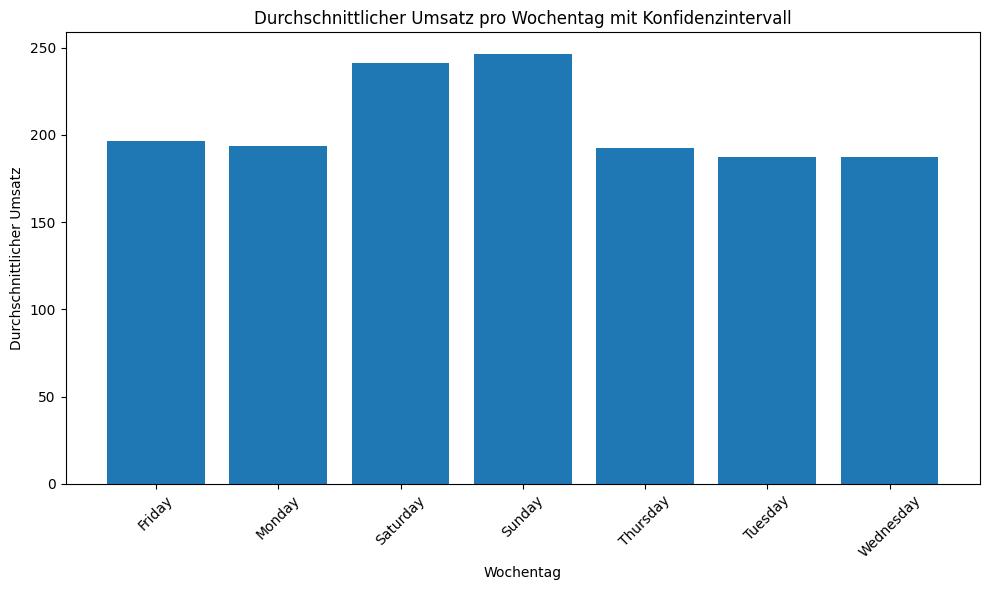

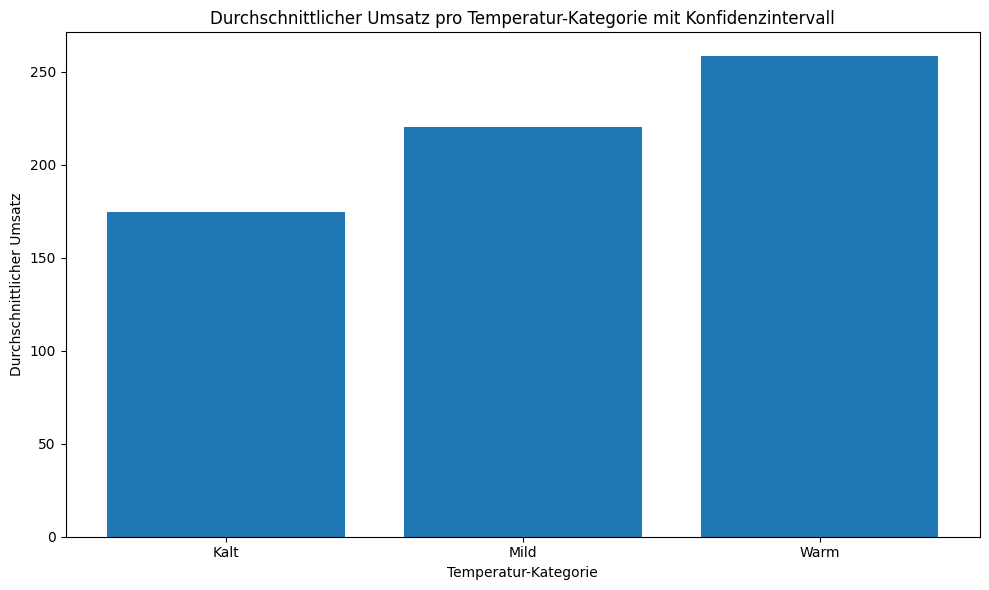

In [45]:
# 4. Zusätzliche Variablen erstellen
merged_data['Wochentag'] = merged_data['Datum'].dt.day_name()
merged_data['Wochentag_Nummer'] = merged_data['Datum'].dt.weekday
merged_data['Monat'] = merged_data['Datum'].dt.month
merged_data['Quartal'] = merged_data['Datum'].dt.quarter
merged_data['Ist_Wochenende'] = merged_data['Wochentag'].isin(['Saturday', 'Sunday']).astype(int)
merged_data['Ist_Feiertag'] = merged_data['Name'].notnull().astype(int)

def categorize_temperature(temp):
    if temp < 10:
        return "Kalt"
    elif 10 <= temp < 20:
        return "Mild"
    else:
        return "Warm"

merged_data['Temperatur_Kategorie'] = merged_data['Temperatur'].apply(categorize_temperature)
merged_data['Feiertagsnaehe'] = (
    (merged_data['Ist_Feiertag'] == 1) |
    (merged_data['Datum'] - pd.Timedelta(days=1)).isin(feiertage['Datum']) |
    (merged_data['Datum'] + pd.Timedelta(days=1)).isin(feiertage['Datum'])
).astype(int)
merged_data['Umsatz_Trend_7_Tage'] = merged_data['Umsatz'].rolling(window=7, min_periods=1).mean()

# Fehlende Werte behandeln
merged_data.fillna(0, inplace=True)

# Bar-Charts für alle selbsterstellten Variablen darstellen
variables = ['Wochentag', 'Wochentag_Nummer', 'Monat', 'Quartal', 'Ist_Wochenende',
             'Ist_Feiertag', 'Temperatur_Kategorie', 'Feiertagsnaehe']

for var in variables:
    plt.figure(figsize=(10, 6))
    if var == 'Wochentag_Nummer':
        # Sortieren nach Wochentag-Nummer
        data = merged_data.groupby(var)['Umsatz'].mean().sort_index()
    else:
        # Gruppieren nach Variable und durchschnittlichen Umsatz berechnen
        data = merged_data.groupby(var)['Umsatz'].mean()

    sns.barplot(x=data.index, y=data.values, palette='viridis')
    plt.title(f'Durchschnittlicher Umsatz nach {var}')
    plt.xlabel(var)
    plt.ylabel('Durchschnittlicher Umsatz')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
# 5. Datensatz teilen
train_data = merged_data[(merged_data['Datum'] >= '2013-07-01') & (merged_data['Datum'] <= '2017-07-31')]
validation_data = merged_data[(merged_data['Datum'] >= '2017-08-01') & (merged_data['Datum'] <= '2018-07-31')]

In [8]:
# 6. Lineares Modell erstellen
features = ['Wochentag_Nummer', 'Feiertagsnaehe', 'Temperatur', 'Ist_Wochenende']
X_train = train_data[features]
y_train = train_data['Umsatz']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# 7. Adjustiertes R² berechnen
n = len(y_train)
p = X_train.shape[1]
r2 = model.score(X_train, y_train)
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Ergebnisse ausgeben
print("R²:", r2)
print("Adjustiertes R²:", adj_r2)

R²: 0.07196908746722364
Adjustiertes R²: 0.07147532268268908


In [10]:
# 8. Ergebnisse speichern
output_dir = "Baseline Model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Ergebnisse dokumentieren
with open(os.path.join(output_dir, "results.txt"), "w") as f:
    f.write(f"R²: {r2}\n")
    f.write(f"Adjustiertes R²: {adj_r2}\n")

train_data.to_csv(os.path.join(output_dir, "train_data.csv"), index=False)
validation_data.to_csv(os.path.join(output_dir, "validation_data.csv"), index=False)

In [11]:
# 9. Sample Submission laden
submission_file = "sample_submission.csv"
if not os.path.exists(submission_file):
    raise FileNotFoundError(f"Datei '{submission_file}' nicht gefunden.")

submission = pd.read_csv(submission_file)

# IDs aus der sample_submission.csv übernehmen
submission_ids = submission['id']

# Umsatz mit dem Modell vorhersagen
X_val = validation_data[features]
y_pred = model.predict(X_val)

# Sicherstellen, dass die Länge übereinstimmt
if len(y_pred) != len(submission):
    y_pred = y_pred[:len(submission)]

# Umsatzwerte in die Submission-Datei einfügen
submission['Umsatz'] = y_pred

# IDs aus der sample_submission.csv wiederherstellen
submission['id'] = submission_ids

# Datum-Spalte entfernen, falls vorhanden
if 'Datum' in submission.columns:
    submission = submission.drop(columns=['Datum'])

# Submission speichern
submission.to_csv("submission.csv", index=False)

print("Sample Submission aktualisiert und gespeichert als 'submission.csv'.")
print("Berechnungen abgeschlossen und Ergebnisse gespeichert.")

Sample Submission aktualisiert und gespeichert als 'submission.csv'.
Berechnungen abgeschlossen und Ergebnisse gespeichert.


Epoch 1/50


c:\Users\ayham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 56072.5078 - mae: 185.4681 - val_loss: 18207.9551 - val_mae: 104.8940
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22050.4785 - mae: 112.6558 - val_loss: 16496.9727 - val_mae: 100.7216
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20885.7305 - mae: 111.6523 - val_loss: 16430.3164 - val_mae: 101.8188
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20999.0781 - mae: 111.7187 - val_loss: 16042.9072 - val_mae: 100.2229
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21130.2871 - mae: 110.0289 - val_loss: 15803.8828 - val_mae: 99.2047
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21991.9980 - mae: 111.4381 - val_loss: 15575.8447 - val_mae: 98.1237
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20362.9434 - mae: 110.6644 - val_loss: 16222.7041 - val_mae: 102.2019
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21396.7246 - mae: 111.9358 - val_loss: 1538

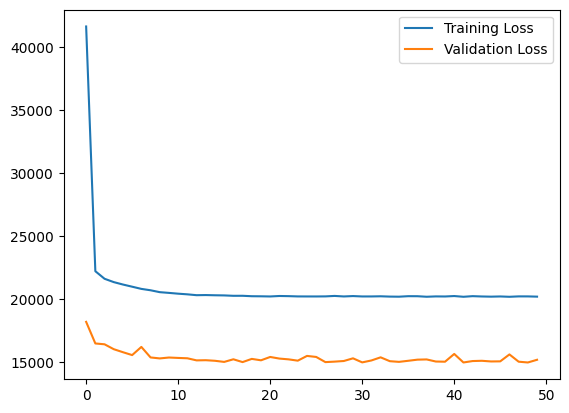

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [12]:
# 10. Neuronales Netz erstellen
neural_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Regressionsausgabe
])

# Modell kompilieren
neural_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Modell trainieren
history = neural_model.fit(X_train, y_train, validation_data=(X_val, validation_data['Umsatz']), epochs=50, batch_size=32)

# Trainingsergebnisse visualisieren
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Vorhersagen auf Testdaten durchführen
y_pred = neural_model.predict(X_val)

# Sicherstellen, dass die Länge übereinstimmt
if len(y_pred) != len(validation_data):
    y_pred = y_pred[:len(validation_data)]

In [13]:
# 11. Code-Verbesserung für fehlende Werte

# Numerische Variablen durch Median ersetzen
for col in merged_data.select_dtypes(include=['float64', 'int64']).columns:
    merged_data[col].fillna(merged_data[col].median(), inplace=True)

# Kategorische Variablen durch Modus ersetzen
for col in merged_data.select_dtypes(include=['object']).columns:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

C:\Users\ayham\AppData\Local\Temp\ipykernel_6564\1435289937.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(merged_data[col].median(), inplace=True)
C:\Users\ayham\AppData\Local\Temp\ipykernel_6564\1435289937.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [14]:
# 12. Datenoptimierung

# Numerische Variablen skalieren
scaler = StandardScaler()
numeric_features = ['Wochentag_Nummer', 'Feiertagsnaehe', 'Temperatur', 'Umsatz_Trend_7_Tage']

merged_data[numeric_features] = scaler.fit_transform(merged_data[numeric_features])

# Sicherstellen, dass die Temperatur_Kategorie-Spalte vorhanden ist
if 'Temperatur_Kategorie' not in merged_data.columns:
    merged_data['Temperatur_Kategorie'] = merged_data['Temperatur'].apply(categorize_temperature)

# Kategorische Variablen kodieren
merged_data = pd.get_dummies(merged_data, columns=['Temperatur_Kategorie'], drop_first=True)

# Überprüfen, ob die Dummy-Variablen erstellt wurden
for category in ['Temperatur_Kategorie_Mild', 'Temperatur_Kategorie_Warm']:
    if category not in merged_data.columns:
        merged_data[category] = 0

# Trainings- und Validierungsdaten aktualisieren
features = ['Wochentag_Nummer', 'Feiertagsnaehe', 'Temperatur', 'Umsatz_Trend_7_Tage', 'Temperatur_Kategorie_Mild', 'Temperatur_Kategorie_Warm']

# Update train_data and validation_data with new features
train_data = merged_data[(merged_data['Datum'] >= '2013-07-01') & (merged_data['Datum'] <= '2017-07-31')]
validation_data = merged_data[(merged_data['Datum'] >= '2017-08-01') & (merged_data['Datum'] <= '2018-07-31')]

X_train = train_data[features]
y_train = train_data['Umsatz']
X_val = validation_data[features]
y_val = validation_data['Umsatz']

Epoch 1/100


c:\Users\ayham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 54500.0703 - mae: 187.9863 - val_loss: 4951.3887 - val_mae: 52.4282
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6250.9346 - mae: 52.1504 - val_loss: 2964.9202 - val_mae: 36.9560
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4448.3022 - mae: 44.4905 - val_loss: 2778.2375 - val_mae: 35.1492
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4475.1104 - mae: 43.9808 - val_loss: 2620.3994 - val_mae: 33.7107
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3984.2537 - mae: 40.7570 - val_loss: 2524.8499 - val_mae: 32.8251
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4556.5098 - mae: 42.6400 - val_loss: 2407.3572 - val_mae: 31.5415
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4193.4307 - mae: 41.0326 - val_loss: 2361.3125 - val_mae: 30.9721
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3851.9170 - mae: 40.5118 - val_loss: 2367.1357 - val_mae: 30

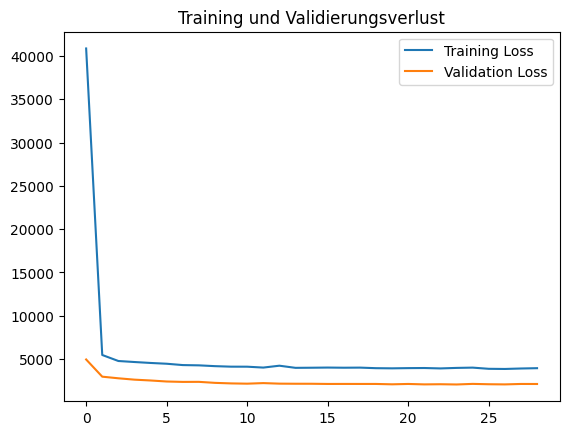

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample Submission aktualisiert und gespeichert als 'submission.csv'.


In [15]:
# 13. Modelloptimierung

# Neuronales Netz erstellen
neural_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Regressionsausgabe
])

# Early Stopping, um Übertraining zu verhindern
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modell kompilieren
neural_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Modell trainieren
history = neural_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                           epochs=100, batch_size=32, callbacks=[early_stopping])

# Trainingsergebnisse visualisieren
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training und Validierungsverlust")
plt.show()

# Vorhersagen auf Testdaten durchführen
y_pred = neural_model.predict(X_val)

# Sicherstellen, dass die Länge übereinstimmt
if len(y_pred) != len(submission):
    y_pred = y_pred[:len(submission)]

# Umsatzwerte in die Submission-Datei einfügen
submission['Umsatz'] = y_pred.flatten()

# IDs aus der sample_submission.csv wiederherstellen
submission['id'] = submission_ids

# Submission speichern
submission.to_csv("submission.csv", index=False)

print("Sample Submission aktualisiert und gespeichert als 'submission.csv'.")

In [ ]:
# 14. MAPE für den gesamten Validierungsdatensatz berechnen
y_val_pred = neural_model.predict(X_val)

# Überprüfen, ob die Vorhersagen die gleiche Länge wie die tatsächlichen Werte haben
if len(y_val_pred) != len(y_val):
    print(f"Warnung: Die Länge der Vorhersagen ({len(y_val_pred)}) stimmt nicht mit der Länge der tatsächlichen Werte ({len(y_val)}) überein.")
    y_val_pred = y_val_pred[:len(y_val)]  # Kürze die Vorhersagen, um sie mit den tatsächlichen Werten abzugleichen

# MAPE für den gesamten Validierungsdatensatz
mape_total = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"MAPE für den gesamten Validierungsdatensatz: {mape_total:.4f}")

# MAPE für jede Warengruppe berechnen
# Angenommen, du hast eine Spalte namens 'Warengruppe' in merged_data
# Stelle sicher, dass die Warengruppe-Spalte in deinen Trainings- und Validierungsdatensatz integriert ist
if 'Warengruppe' not in merged_data.columns:
    raise KeyError("Die Spalte 'Warengruppe' ist im Datensatz nicht vorhanden.")

# Berechne MAPE für jede Warengruppe
warengruppen = merged_data['Warengruppe'].unique()
mape_by_group = {}

for group in warengruppen:
    # Filtere die Validierungsdaten nach Warengruppe
    group_val_data = validation_data[validation_data['Warengruppe'] == group]
    X_group_val = group_val_data[features]
    y_group_val = group_val_data['Umsatz']
    
    # Vorhersagen für diese Warengruppe
    y_group_pred = neural_model.predict(X_group_val)
    
    # Überprüfen, ob die Vorhersagen und tatsächlichen Werte für jede Warengruppe die gleiche Länge haben
    if len(y_group_pred) != len(y_group_val):
        print(f"Warnung: Die Länge der Vorhersagen für Warengruppe '{group}' ({len(y_group_pred)}) stimmt nicht mit der Länge der tatsächlichen Werte ({len(y_group_val)}) überein.")
        y_group_pred = y_group_pred[:len(y_group_val)]  # Kürze die Vorhersagen, um sie mit den tatsächlichen Werten abzugleichen

    # MAPE für diese Warengruppe berechnen
    mape_group = mean_absolute_percentage_error(y_group_val, y_group_pred)
    mape_by_group[group] = mape_group

    print(f"MAPE für Warengruppe '{group}': {mape_group:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Warnung: Die Länge der Vorhersagen (1881) stimmt nicht mit der Länge der tatsächlichen Werte (1830) überein.
MAPE für den gesamten Validierungsdatensatz: 0.1737
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAPE für Warengruppe '1': 0.2678
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAPE für Warengruppe '2': 0.1089
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAPE für Warengruppe '3': 0.1591
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAPE für Warengruppe '4': 0.1813
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAPE für Warengruppe '5': 0.1404
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAPE für Warengruppe '6': 0.4409


In [43]:
# 15. Berechne die absoluten Fehler
validation_data['Fehler'] = abs(y_val - y_val_pred.flatten())

# Worst Fail: Maximale Fehlergröße
worst_fail = validation_data.loc[validation_data['Fehler'].idxmax()]

# Best Improvement: Minimale Fehlergröße
best_improvement = validation_data.loc[validation_data['Fehler'].idxmin()]

# Ausgabe der Worst Fail und Best Improvement Ergebnisse
print(f"Worst Fail: \n{worst_fail}")
print(f"Best Improvement: \n{best_improvement}")

Worst Fail: 
Datum                        2017-12-31 00:00:00
Warengruppe                                    5
Umsatz                               1432.422347
KielerWoche                                  0.0
Bewoelkung                                   7.0
Temperatur                             -0.517615
Windgeschwindigkeit                         16.0
Wettercode                                  63.0
Name                                           0
Wochentag                                 Sunday
Wochentag_Nummer                        1.501884
Monat                                         12
Quartal                                        4
Ist_Wochenende                                 1
Ist_Feiertag                                   0
Feiertagsnaehe                         -0.256849
Umsatz_Trend_7_Tage                     1.729359
Temperatur_Kategorie_Mild                  False
Temperatur_Kategorie_Warm                  False
Fehler                                891.917709
Name: 8